# Corso di Quantum Computing - Giorno 2

In questo notebook Jupyter vedremo come costruire un sistema in entanglement, come implementare l'algoritmo di Deutsch-Josza e come tradurre la QFT in forma di circuito.

Inoltre, introdurremo anche le **Primitives**, funzioni cardine volte alla costruzione di agoritmi modulari complessi. Le due funzioni principali che analizzeremo saranno
* **Sampler**, che genera la quasi-distribuzione di probabilità dal circuito di input;
* **Estimator**, che calcola il valore atteso dal circuito di input e dagli osservabili.

Infine, introdurremo anche la **programmazione dinamica**, la cui caratteristica distintiva è la presenza di misurazioni di qubit all'interno della computazione, che poi continua ad evolvere sfruttando anche i risultati di tali misurazioni.

Corso per Epigenesys s.r.l. <br>
Docenti: Sara Galatro e Lorenzo Gasparini <br>
Supervisore: Prof. Marco Pedicini

## Per iniziare

Il primo step è ovviamente quello di importare le librerie di cui abbiamo bisogno, includendo in particolar modo le primitive `Sampler` e `Estimator` da Qiskit.

Per eseguire il nostro codice sul quantum computer la sintassi è leggermente diversa, ma per oggi continueremo ad usare i simulatori, così da poter analizzare e comprenderne al meglio il funzionamento prima di trasferirci al vero quantum hardware (anche per una questione di efficienza e di tempo a disposizione).

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit import transpile, assemble
from qiskit.quantum_info.operators import Operator
from qiskit import Aer
from qiskit.primitives import Estimator, Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_histogram, array_to_latex

import numpy as np
import matplotlib.pyplot as plt

## Primitives vs Misurazioni

Definire un circuito come abbiamo fatto non equivale però ad *eseguirlo*: infatti, a tal fine, abbiamo bisogno di chiamare il simulatore o il quantum computer stesso, utilizzando le funzioni apposite.

Una prima possibilità per eseguire un circuito consiste nel utilizzare le primitive `Sampler` ed `Estimator`, le quali non ci forniscono il risultato della computazione nello specifico, ma la distribizione di probabilità e il valor medio degli output, rispettivamente.

Per introdurre tali primitive, definiamo ora due circuiti: il primo farà evolvere il sistema allo stato eccitato $|1\rangle$, mentre il secondo manderà $|0\rangle$ nella sovrapposizione equiprobabile $|+\rangle$.

Procederemo poi alla misurazione di tali circuiti, prima tramite `Sampler` e poi tramite `Estimator`, così da raggiungere due obiettivi importanti di questa prima parte di laboratorio:
1. prendere confindenza con questi due nuovi e potenti strumenti;
2. osservare che non dobbiamo preoccuparci di ruotare ogni volta i nostri qubit al fine di trovarci nella base corretta di misurazione.

Specifichiamo che le primitive saranno eseguite all'interno del contesto `Session`, il quale permette di ottimizzare il carico di lavoro.

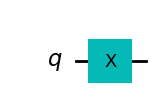

In [2]:
# create excited |1> state
qc_1 = QuantumCircuit(1)
qc_1.x(0)
qc_1.draw('mpl')


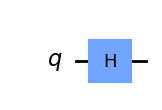

In [3]:
# create superposition |+> state
qc_plus = QuantumCircuit(1)
qc_plus.h(0)
qc_plus.draw('mpl')

### Sampler Primitive

Iniziamo dalla primitiva `Sampler` e misuriamo i nostri qubit nella base $Z$, ossia la vera base fisica in cui i qubit possono essere misurati.

Ciò che farà il `Sampler` sarà contare le occorrenze dei possibili risultati $|0\rangle,|1\rangle$ e normalizzerà tali quantità dividendo per il numero di *shots*, ossia per il numero di esperimenti condotti. Il `Sampler` offre anche la possibilità di *mitigare facilmente gli errori* dovuti all'hardware (tema che affronteremo meglio l'ultimo giorno di corso) modificando la computazione: per questo motivo i risultati del `Sampler` sono detti *quasi-probabilità*.

Specifichiamo che, quando si usa la primitiva `Sampler`, le misurazioni devono essere inserite esplicitamente nel circuito in analisi. 

A questo punto, si apre il contesto `Session`, il `Sampler` è inizializzato e tramite il comando `sampler.run()` il circuito viene inviato al backend ed eseguito.

In [4]:
qc_1.measure_all() # add measurements
qc_plus.measure_all() # add measurements

# sampler call
sampler = Sampler()
job_1 = sampler.run(qc_1)
job_plus = sampler.run(qc_plus)

In [5]:
job_1.result().quasi_dists

[{1: 1.0}]

In [6]:
job_plus.result().quasi_dists

[{0: 0.4999999999999999, 1: 0.4999999999999999}]

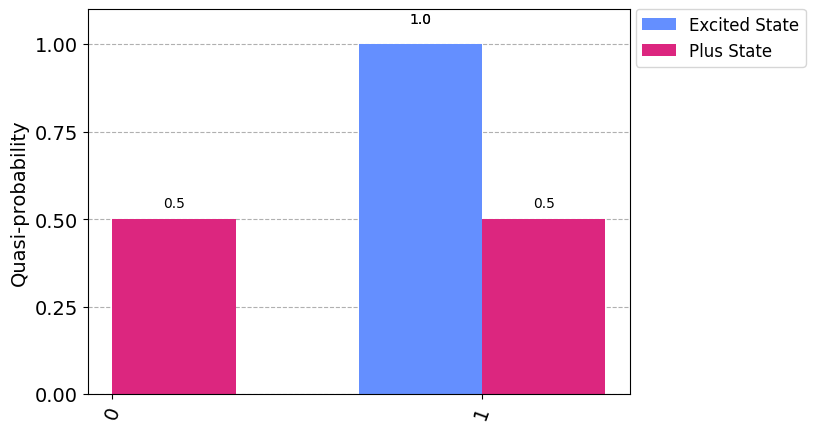

In [7]:
legend = ["Excited State", "Plus State"]
plot_histogram([job_1.result().quasi_dists[0], job_plus.result().quasi_dists[0]], legend=legend)

Osserviamo che il risultato della misurazione dello stato eccitato è, come previsto, sempre lo stato $1$, mentre invece gli output della misurazione dello stato $|+\rangle$ sono più o meno bilanciati.

Questi risultati sono in linea anche con il fatto che stiamo misurando rispetto alla base computazionale canonica, i.e. $Z$, così chiamata facendo riferimento all'operatore $\mathbf{Z}$, i cui autovettori sono proprio $|0\rangle$ e $|1\rangle$ (con autovalori $+1$ e $-1$ rispettivamente).

Cambiamo base ora e misuriamo rispetto alla base $X$. Usando `Sampler`, dobbiamo ruotare il nostro qubit dalla base $X$ alla base $Z$, dato che è l'unica base rispetto a cui possiamo fisicamente eseguire la misurazione.

In [8]:
# remove measurements
qc_1.remove_final_measurements()
qc_plus.remove_final_measurements()

# rotate into the X-basis
qc_1.h(0)
qc_plus.h(0)

# add measurements
qc_1.measure_all()
qc_plus.measure_all()

In [9]:
sampler = Sampler()
job_1 = sampler.run(qc_1)
job_plus = sampler.run(qc_plus)

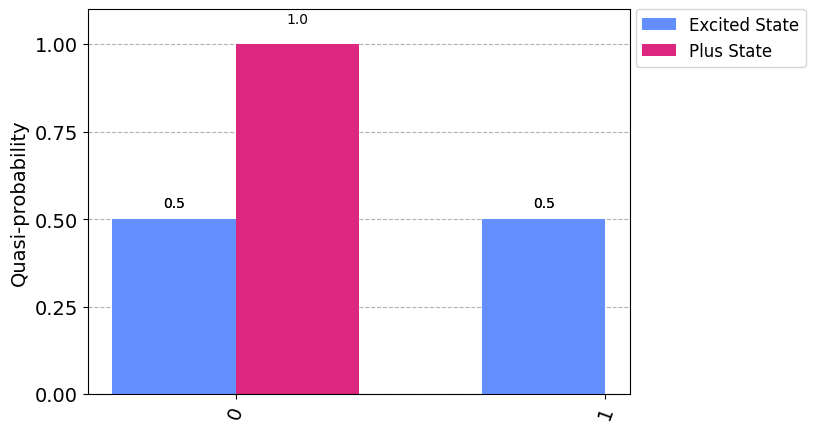

In [10]:
plot_histogram([job_1.result().quasi_dists[0], job_plus.result().quasi_dists[0]], legend=legend)

Osserviamo che ora otteniamo dei risultati esattamente opposti ai precedenti: la sovrapposizione equiprobabile ha probabilità $1$, mentre lo stato eccitato ha una distribuzione pressoché uniforme sugli output.

Nuovamente, questo risultato è dovuto al fatto che $|+\rangle$ è un autovettore di $X$ con autovalore $+1$ (come anche $|-\rangle$ con autovalore $-1$). Questo tipo di informazione è utile per analizzare i risultati del `Sampler`, ma lo saranno ancora di più ora che useremo l'`Estimator`.

### Estimator Primitive

La primitiva Qiskit `Estimator` ci permette di analizzare nuovamente le misurazioni, stavolta specificando un *osservabile*. In particolare, possiamo costruire gli stessi circuiti di prima, solo che in questo caso non è necessario aggiungere esplicitamente le misurazioni: ciò che faremo, invece, sarà specificare una lista di osservabili sotto forma di stringhe formate dagli operatori di Pauli.

Nel nostro caso, dato che vogliamo misurare un singolo qubit, ci basterà specificare `'Z'` per la base $Z$ e `'X'` per la base $X$.

In [11]:
qc2_1 = QuantumCircuit(1)
qc2_1.x(0)

qc2_plus = QuantumCircuit(1)
qc2_plus.h(0)

obsvs = list(SparsePauliOp(['Z', 'X']))

In [12]:
estimator = Estimator()
job2_1 = estimator.run([qc2_1]*len(obsvs), observables=obsvs)
job2_plus = estimator.run([qc2_plus]*len(obsvs), observables=obsvs)

In [13]:
job2_1.result()

EstimatorResult(values=array([-1.,  0.]), metadata=[{}, {}])

In [14]:
def print_table(ph_1, ph_plus): 
    # funzione stampa ausiliaria per ottenere
    # una tabella carina e leggibile 
    # sezione: estimator

    # placeholder list
    ph_list = [[" ", "|", "<Z>", "|", "<X>"], 
            ["|1>", "|", ph_1.values[0], "|", ph_1.values[1]], 
            ["|+>", "|", ph_plus.values[0], "|", ph_plus.values[1]]
            ]
    
    # print table
    for row in ph_list:
        print(''.join(f'{x:^15}' for x in row)) # 15 chars wide centered columns
        print('-------------------------------------------------------------------------------------')


In [15]:
# print table w/ results
print_table(job2_1.result(),job2_plus.result())

                      |             <Z>             |             <X>      
-------------------------------------------------------------------------------------
      |1>             |            -1.0             |             0.0      
-------------------------------------------------------------------------------------
      |+>             |             0.0             |       0.9999999999999998
-------------------------------------------------------------------------------------


Proprio come nel caso precedente, otteniamo che il valore atteso relativo a $|1\rangle$ nella base $Z$ è il suo autovalore $-1$, mentre nella base $X$ tale valore atteso è zero (dato che è la media tra i due autovalori $\pm 1$). 

Per lo stato $|+\rangle$ la situazione è, nuovamente, ribaltata, pur considerando che l'autovalore in questo caso è $+1$.

## Teletrasporto

<center>

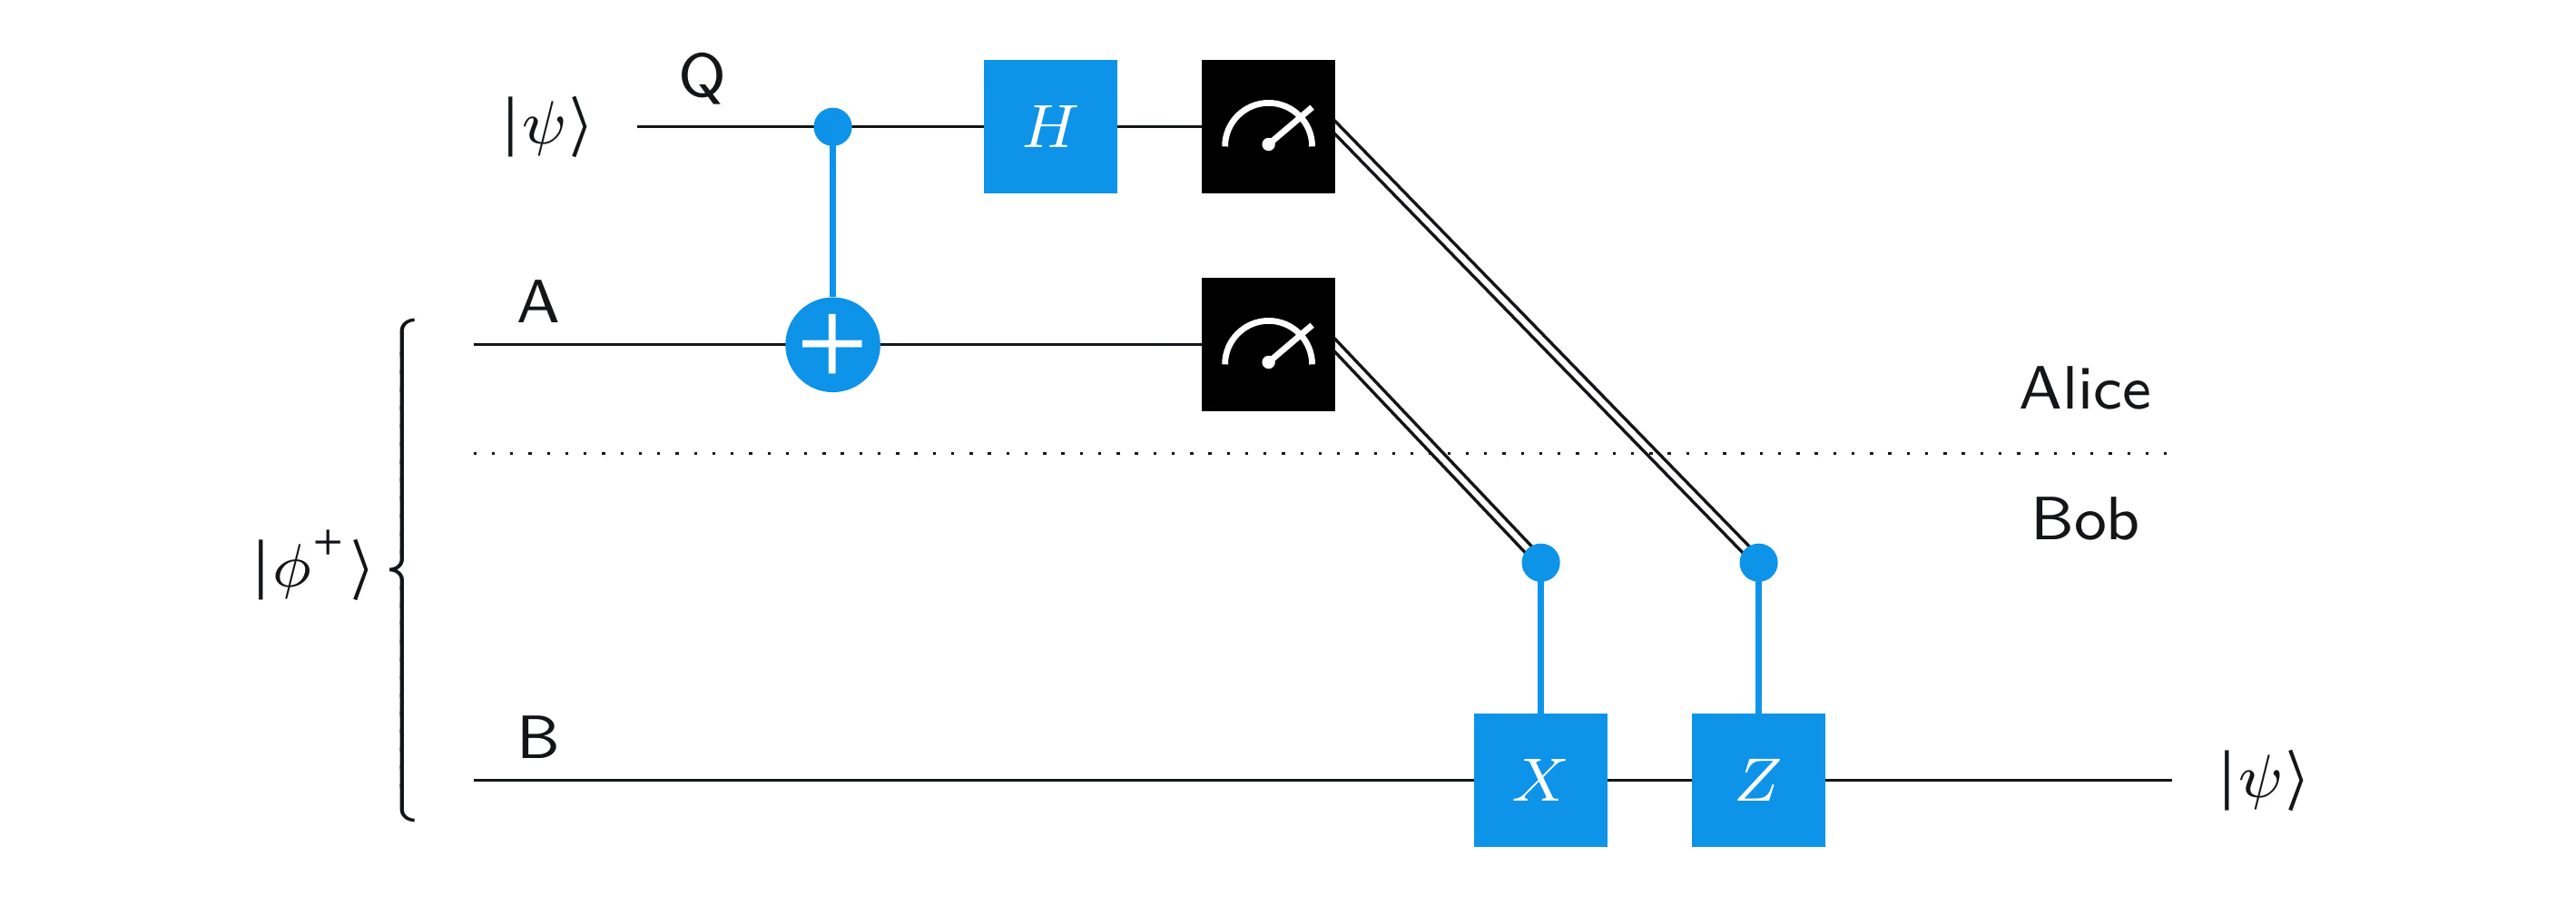

</center>

Abbiamo visto, attraverso il *No Cloning Theorem*, che l'informazione quantistica non può essere copiata. Nonostante ciò, tale informazione può essere "teletrasportata": infatti, dato un qubit in entanglement con una risorsa quantistica, possiamo ricostruire lo stato del qubit originale su un diverso qubit tramite un protocollo di misurazioni e *comunicazioni classiche*. É importante però osservare che l'informazione originale sul primo qubit viene distrutta a causa delle misurazioni.

In questo esercizio, costruiremo un qubit con uno stato fissato e poi lo trasferiremo a un altro qubit usando suddetto protocollo. 

Definiamo lo stato $|\psi\rangle$ ruotando il nostro qubit di un angolo $\theta$ pari a $\frac{5\pi}{7}$, le cui probabilità associate sono
$$
    \mathbb{P}(0) \approx 0.20  \qquad  \mathbb{P}(1) \approx 0.80
$$

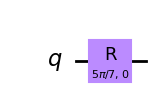

In [16]:
qr = QuantumRegister(1, 'q')
qc = QuantumCircuit(qr)

qc.r(theta = 5*np.pi/7, phi = 0, qubit = 0)

qc.draw('mpl')

Alice possiede l'informazione quantistica $|\psi\rangle$ come stato di $q$ e desidera inviarla a Bob. Inoltre, Alice e Bob condividono un sistema che si trova nello stato di entanglement
$$
|   \Phi^+\rangle = \frac{1}{2} \left( |00\rangle + |11\rangle \right)
$$
dove il primo qubit è di Alice e il secondo è di Bob. Dunque, Alice avrà un registro a due qubit ($q$ e $Bell_0$), mentre Bob avrà un registro con un solo qubit ($Bell_1$).

Costruiamo quindi il circuito copiando l'originale `qc` e aggiungiamo i registri mancanti.

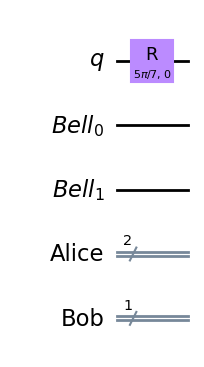

In [17]:
tele_qc = qc.copy()

bell = QuantumRegister(2, 'Bell')
alice = ClassicalRegister(2, 'Alice')
bob = ClassicalRegister(1, 'Bob')
tele_qc.add_register(bell, alice, bob)

tele_qc.draw('mpl')

Creiamo ora lo stato di Bell, stando attenti a dare $Bell_0$ ad Alice e $Bell_1$ a Bob: andremo dunque a porre un Hadamard gate sul registro $Bell_0$, così da portarlo nello stato $|+\rangle$, e poi applicheremo un $\mathbf{CNOT}$ usando sempre lo stesso qubit come controllo.

Dopo aver ricevuto i rispettivi qubit, Alice e Bob si separano.

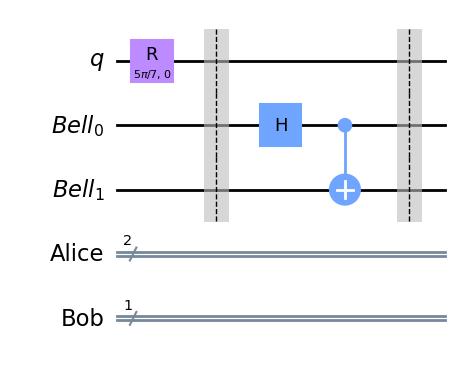

In [18]:
# create Bell state with other two qubits
tele_qc.barrier()

tele_qc.h(1)
tele_qc.cx(1, 2)

tele_qc.barrier()

tele_qc.draw('mpl')

Succesivamente, Alice esegue un $\mathbf{CNOT}$ con controllo su $q$ e target in $Bell_0$, mappando così l'informazione dello stato in $q$. Applica poi un Hadamard gate.

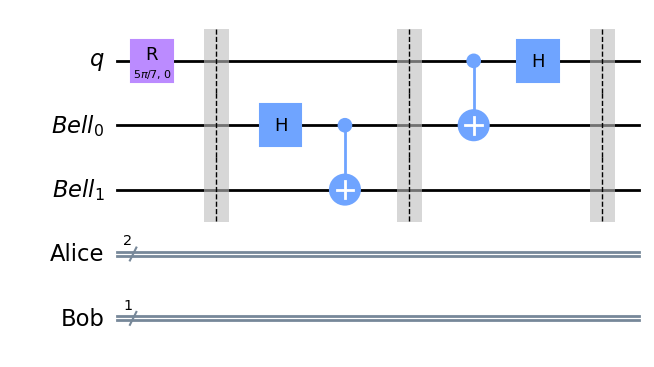

In [19]:
# alice operates on her qubits
tele_qc.cx(0, 1)
tele_qc.h(0)

tele_qc.barrier()

tele_qc.draw('mpl')

Ora Alice misura i suoi qubit e salva i risultati nel suo registro classico.

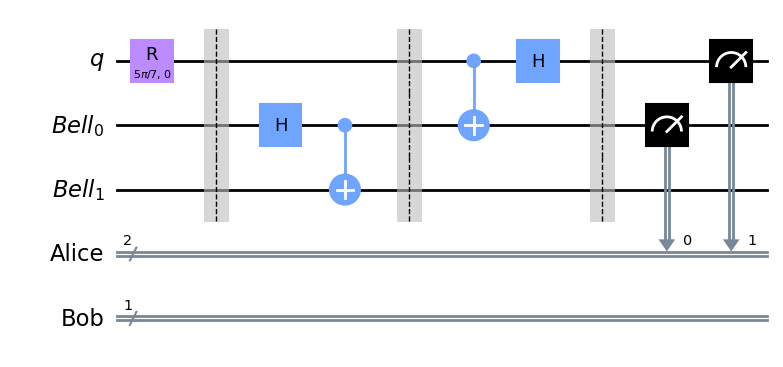

In [20]:
tele_qc.measure([bell[0], qr[0]], alice)
tele_qc.draw('mpl')

Il qubit di Bob, a questo punto, contiene l'informazione $|\psi\rangle$ del qubit di Alice codificata in $Bell_1$, ma non sa ancora in che base misurare al fine di estrarla correttamente. 

A tal fine, Alice comunica tale informazione a Bob via un canale di comunicazione *classico*, motivo per cui il teletrasporto non viola la relatività speciale, a prescindere di quanto Alice e Bob siano distanti. 

Alice dice dunque a Bob di applicare un $\mathbf{X}$ gate se il suo misuramento su $Bell_0$ dà $1$, seguito da uno $\mathbf{Z}$ gate se invece la misurazione di $q$ dà $1$.

L'applicazione condizionata di questi due gate può essere applicata alle misurazioni in due modi:
* l'istruzione `.c_if()`, che applica il gate relativo se il registro classico specificato ha lo stesso valore dato nella condizione. Osserviamo però che tale istruzione funziona **solo** sui simulatori. Per chiarire il concetto, riportiamo un esempio

<center>

```
            qc.y(1).c_if(0, 1) # apply y gate if bit 0 is set to 1
```

</center>


* il contesto `.if_test()`, che agisce nello stesso modo, ma generalizza la sintassi al fine di permettere condizioni innestate. Questa costruzione funziona sia sui simulatori che sul vero hardware.

**Ex 1 - Aggiungete i giusti gate condizionati per trasformare il qubit di Bob secondo il protocollo**

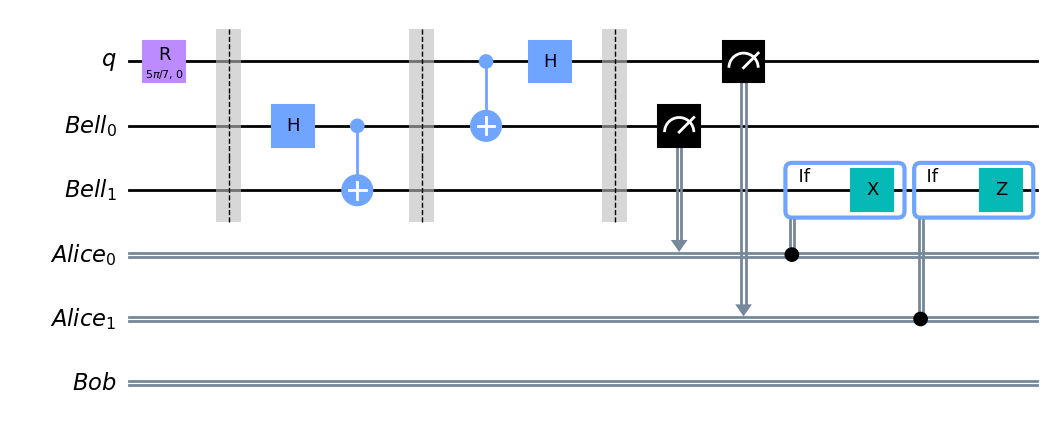

In [21]:
graded_qc = tele_qc.copy()

##############################
# add gates here

with graded_qc.if_test((alice[0], 1)) as else_:
    graded_qc.x(bell[1])
with graded_qc.if_test((alice[1], 1)) as else_:
    graded_qc.z(bell[1])

##############################

graded_qc.draw('mpl')

A questo punto, Bob può misurare il suo qubit, la cui misurazione darà un risultato seguendo la stessa distribuzione che aveva lo stato di Alice in origine.

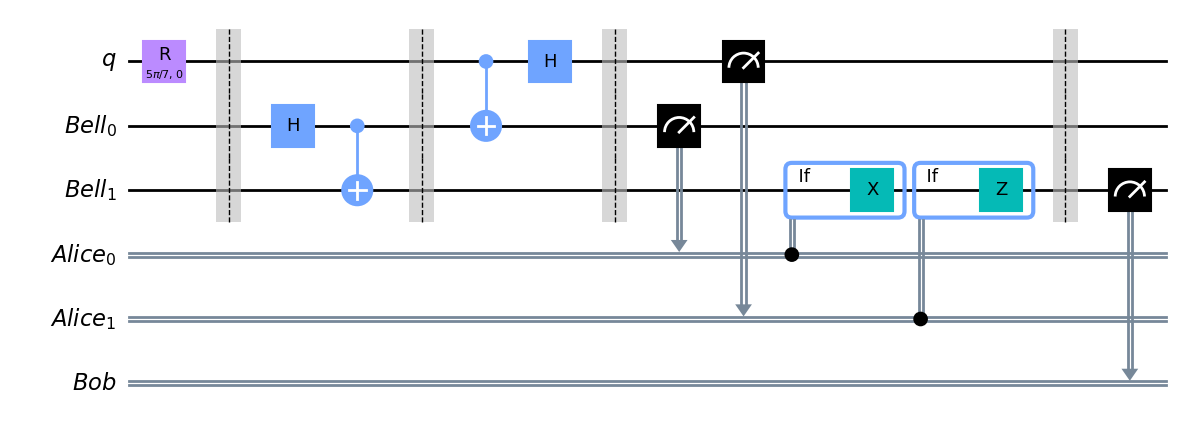

In [22]:
graded_qc.barrier()
graded_qc.measure(bell[1], bob)

graded_qc.draw('mpl')

Nello scorso laboratorio avevamo usato il simulatore dello statevector per ottenere le probabilità dei vari risulati, ma in questo caso non funzionerebbe, data la presenza di misurazioni (che sono operazioni non unitarie) all'interno della computazione.

Importiamo dunque la primitiva `Sampler` da `qiskit_aer` così da poter usare il simulatore `AerSimulator`.

Dopo aver aggiunto la misurazione al circuito originale dotato solo del qubit $q$, eseguiamo entrambi i circuiti per confrontarne gli output.

In [23]:
# add measurements to original qubit
qc.measure_all()

In [24]:
from qiskit_aer.primitives import Sampler

sampler = Sampler()

job_static = sampler.run(qc)
job_dynamic = sampler.run(graded_qc)

print(f"Original Dists: {job_static.result().quasi_dists[0].binary_probabilities()}")
print(f"Teleported Dists: {job_dynamic.result().quasi_dists[0].binary_probabilities()}")

Original Dists: {'0': 0.1826171875, '1': 0.8173828125}
Teleported Dists: {'111': 0.197265625, '101': 0.1904296875, '110': 0.203125, '100': 0.2314453125, '001': 0.0546875, '010': 0.0439453125, '000': 0.0390625, '011': 0.0400390625}


Ma come, i risultati sono diversi!

In realtà questa situazione è perfettamente in linea a ciò che sappiamo: infatti, mentre il circuito originale contiene solo il qubit $q$, il circuito del teletrasporto include le misurazioni di Alice relative a $q$ e $Bell_0$ e la misurazione di Bob relativa a $Bell_1$, nonostante noi siamo solo interessati alla distribuzione di quest'ultima.

Per rettificare ciò, ci basta dunque calcolare le *marginali*, combinando i risultati rispetto ai soli output delle misurazioni di Bob. A tal fine, possiamo utilizzare il [metodo](https://qiskit.org/documentation/stubs/qiskit.result.marginal_counts.html) `marginal_counts` da `qiskit.result`, che somma i risultati rispetto agli indici indicati.

**Ex.2 - Calcolare le marginali**

In [25]:
from qiskit.result import marginal_counts

# add your code here

# PlaceHolder for better readability
ph_results = job_dynamic.result().quasi_dists[0].binary_probabilities()

# marginals
tele_counts = marginal_counts(ph_results, indices=[2])

Se abbiamo marginalizzato correttamente, vedremo che le quasi-distribuzioni delle misurazioni di Alice e di Bob sono pressoché identiche, provando che il teletrasporto ha funzionato!

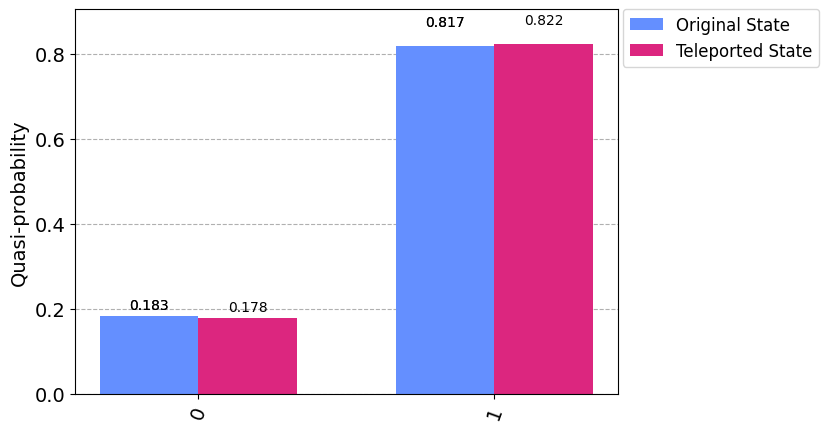

In [26]:
legend = ['Original State', 'Teleported State']
plot_histogram([job_static.result().quasi_dists[0].binary_probabilities(), tele_counts], legend=legend)

## Superdense Coding

Il teletrasporto e il superdense coding sono due protocolli molto simili tra loro e dunque, per evitare di fare confusione, cerchiamo di fissare le idee e le principali differenze.

Il teletrasporto è un processo per cui lo stato $|\psi\rangle$ di un qubit viene trasmesso da un luogo a un altro, usando due bit classici per la comunicazione e un qubit preparato nello stato di Bell: tale protocollo *distrugge* dunque il qubit originale per ricrearlo nel luogo designato di arrivo, sfruttando la risorsa comune in entanglement.

Il superdense coding, invece, è una procedura che permette di inviare due bit classici tramite un solo qubit di comunicazione.

<center>

| Teleportation                                     | Superdense Coding                                    |
|:-------------------------------------------------:|:----------------------------------------------------:|
| Trasmette un<br>qubit usando <br>due bit classici | Trasmette due<br>bit classici <br>usando un qubit |

</center>

Possiamo dunque immaginare il protocollo di teletrasporto come la versione invertita del protocollo del superdense coding, dato che Alice e Bob si "scambiano gli strumenti".

Riportiamo per comodità il circuito visto a lezione poco fa:

<center>

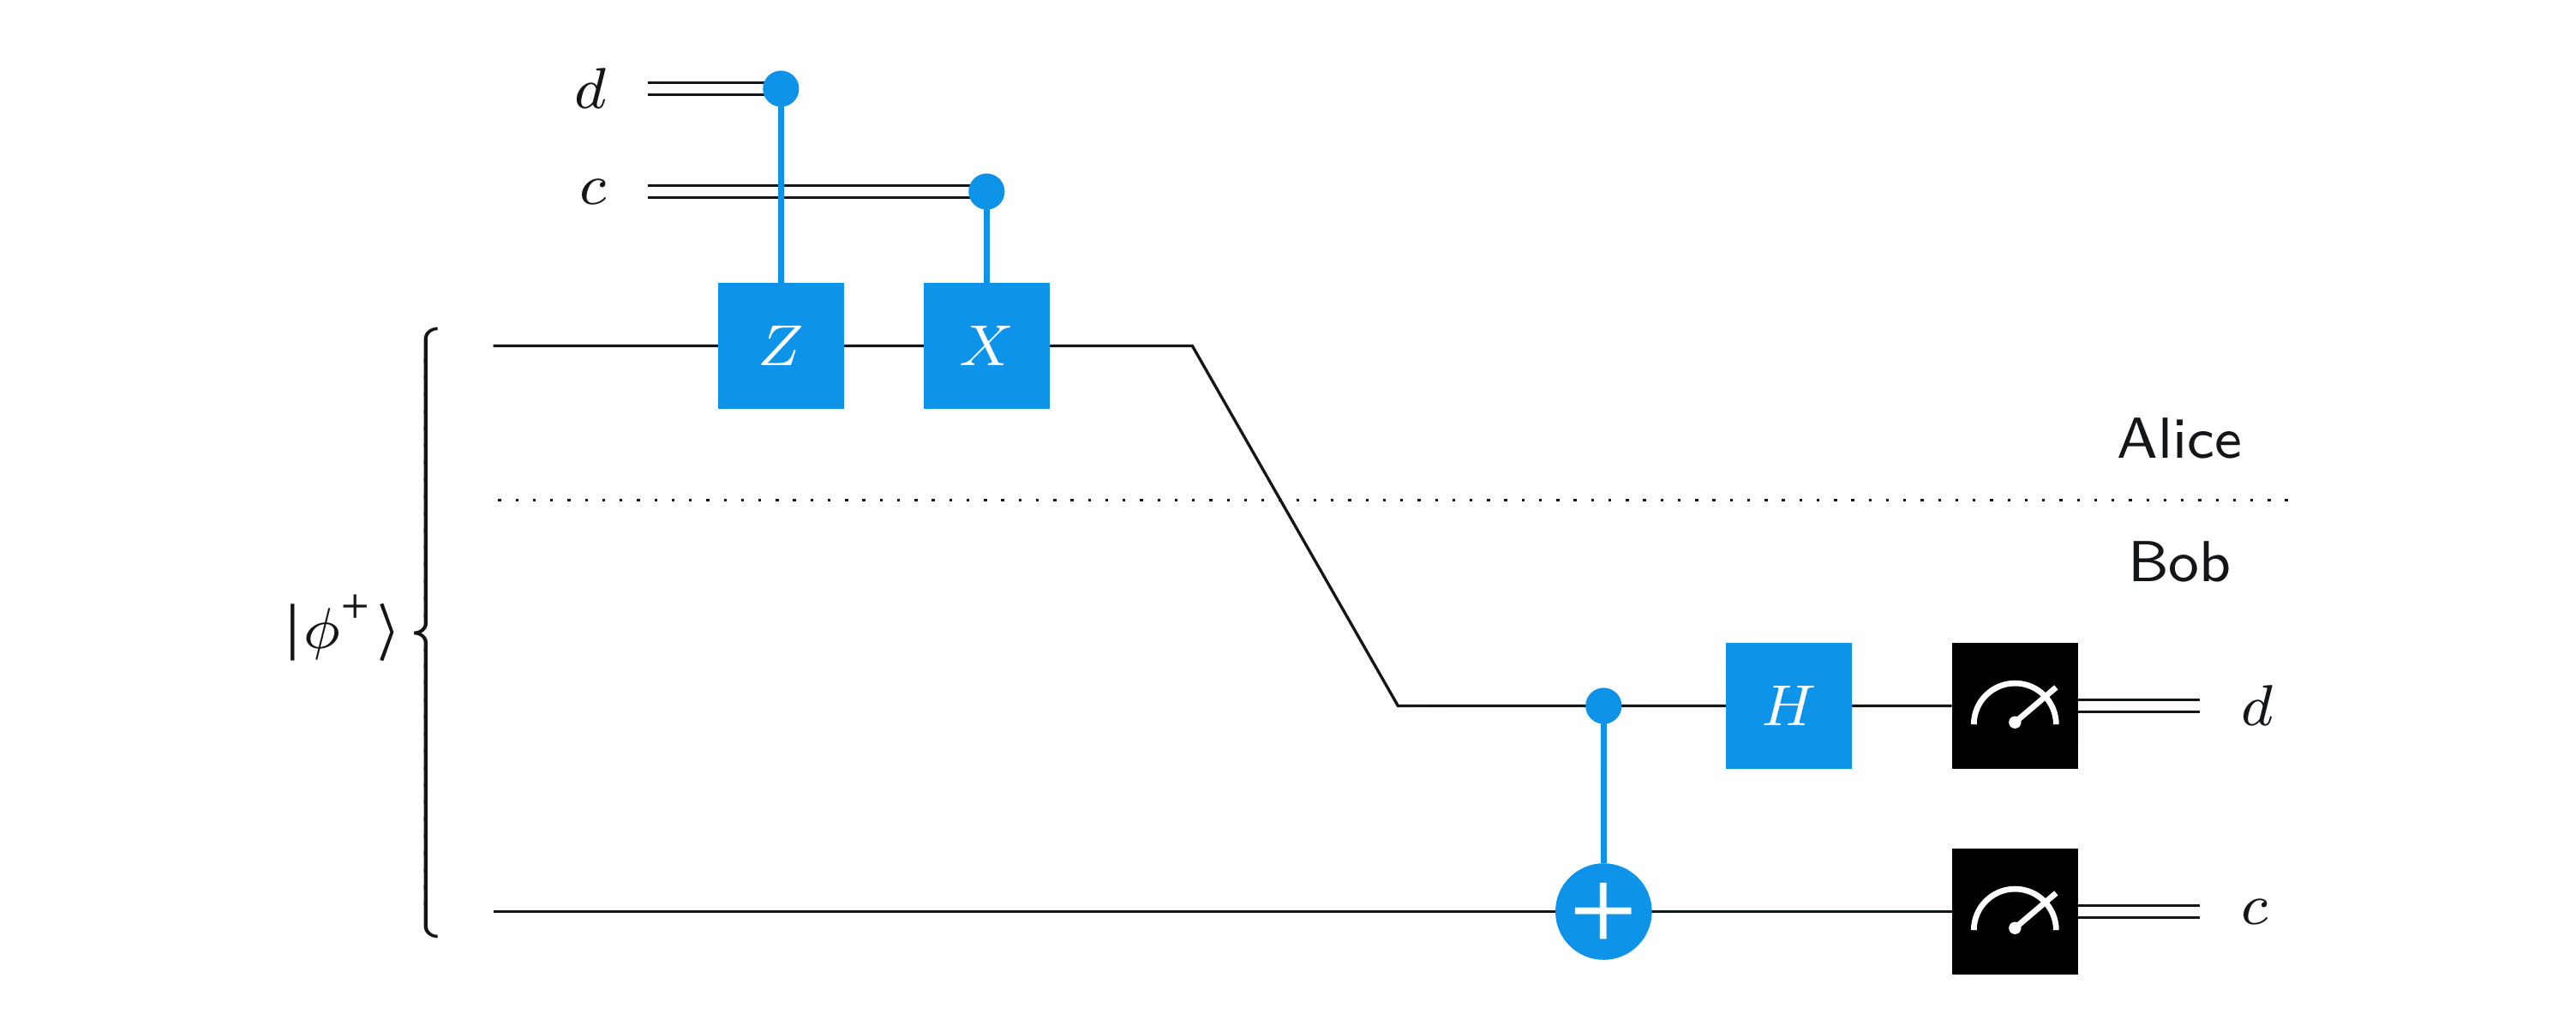

</center>

### L'algoritmo

#### Step 1

Il processo inizia con una terza parte, che chiameremo Charlie, il quale prepara due qubit in uno stato di entanglement usando prima un gate Hadamard sul primo qubit e poi un gate Controlled-Not con controllo sul primo qubit e target sul secondo, così da ottenere una coppia di Bell. 
$$
    |0\rangle_A\otimes |0\rangle_B \equiv |00\rangle
    \overset{\mathbf{H}}{\longrightarrow} 
    \tfrac{1}{\sqrt{2}}(|00\rangle + |10\rangle)
    \overset{\mathbf{CNOT}}{\longrightarrow}
    \tfrac{1}{\sqrt{2}}(|00\rangle + |11\rangle)
$$
dove con i pedici $A,B$ indichiamo a chi sarà inviato il qubit rispettivo.

Osserviamo che questa prima parte coincide con il circuito visto all'inizio del notebook, dove volevamo ottenere per l'appunto lo stato di Bell.

#### Step 2

Charlie invia ora il primo qubit ad Alice e il secondo a Bob.

L'obiettivo del protocollo è che Alice mandi due bit classici a Bob usando il suo qubit $A$. Per far ciò, dovrà innanzitutto applicare delle operazioni a seconda dei valori dei due bit classici che vuole inviare: riassumiamo tali operazioni nella seguente tabella

<center>

<table>
    <tr>
        <th>Intended </th>
        <th>Applied Gate</th>
        <th>Resulting State (per 1/sqrt(2))</th>
    </tr>
    <tr>
        <td>00</td>
        <td>Identità</td>
        <td>|00> + |11></td>
    </tr>
    <tr>
        <td>01</td>
        <td>Bit Flip</td>
        <td>|10> + |01></td>
    </tr>
    <tr>
        <td>10</td>
        <td>Phase Flip</td>
        <td>|00> - |11></td>
    </tr>
    <tr>
        <td>11</td>
        <td>Bit Flip e poi <br> Phase Flip</td>
        <td>-|10> + |01></td>
    </tr>
</table>

</center>

Dunque, se Alice vuole mandare $00$, non fa nulla ai suoi qubit, mentre se invece vuole mandare $01$ applica un bit flip, ossia il gate $\mathbf{X}$.

Dopo aver modificato il suo qubit in base all'informazione classica che vuole inviare, Alice manda il suo qubit a Bob, iniziando così l'ultimo step del protocollo.

### Step 3

Bob riceve quindi il qubit di Alice e lo usa per decodificare il messaggio di Alice. É importante osservare che Bob non ha bisogno di alcuna conoscenza pregressa per decodificare il messaggio, ma gli basta semplicemente applicare l'operazione di recupero.

Dunque, Bob applica un gate $\mathbf{CNOT}$ sul suo qubit usando come controllo il qubit di Alice, per poi eseguire un Hadamard sul qubit di Alice e infine una misurazione, estraendo coì il messaggio di Alice.

<center>

<table>
    <tr>
        <th>Ciò che Bob riceve (per 1/sqrt(2))</th>
        <th>Dopo CNOT-gate (per 1/sqrt(2))</th>
        <th>Dopo H-gate</th>
    </tr>
    <tr>
        <td>|00> + |11></td>
        <td>|00> + |10></td>
        <td>|00></td>
    </tr>
    <tr>
        <td>|10> + |01></td>
        <td>|11> + |01></td>
        <td>|01></td>
    </tr>
    <tr>
        <td>|00> - |11></td>
        <td>|00> - |10></td>
        <td>|10></td>
    </tr>
    <tr>
        <td>-|10> + |01></td>
        <td>-|11> + |01></td>
        <td>|11></td>
    </tr>
</table>

</center>

### Simulare il protocollo di Superdense Coding

**Ex.3 - Inserite i comandi mancanti per definire il circuito del Superdense Coding Protocol**

Per comodità, creiamo una funzione che costruisca il circuito visto a inizio lab, il cui output è lo stato di Bell:

In [27]:
def create_bell_pair(sc_qc):
    
    """
    Args:
        qc (QuantumCircuit): Circuit to build on
    Returns:
        QuantumCircuit: Circuit that produces a Bell pair
    """

    sc_qc.h(0)
    sc_qc.cx(0,1)
    
    return sc_qc

Ora, dobbiamo codificare il nostro messaggio.

Abbiamo visto che ci sono quattro possibili coppie che Alice può inviare: $00,01,10$ o $11$. In base al messaggio, dovremo applicare determinate operazioni e dunque ci conviene definire una funzione che automatizzi tale passaggio:

In [28]:
def encode_message(sc_qc, qubit, msg):

    """Encodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit to encode message on
        qubit (int): Which qubit to add the gate to
        msg (str): Two-bit message to send
    Returns:
        QuantumCircuit: Circuit that, when decoded, will produce msg
    Raises:
        ValueError if msg is wrong length or contains invalid characters
    """

    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
        
    if msg[0] == "1":

        # add your code
        sc_qc.z(qubit)
    
    if msg[1] == "1":

        # add your code
        sc_qc.x(qubit)

    return sc_qc

Infine, ci serve una funzione che si occupi della decodifica del messaggio per Bob:

In [29]:
def decode_message(sc_qc):

    """Decodes a two-bit message on qc using the superdense coding protocol
    Args:
        qc (QuantumCircuit): Circuit with encoded message on
    Returns:
        QuantumCircuit: Decoded Circuit
    """

    # add your code here
    sc_qc.cx(0,1)
    sc_qc.h(0)

    return sc_qc

Costruiamo dunque il nostro protocollo completo:

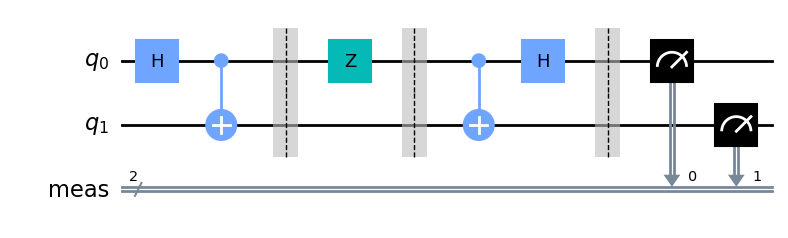

In [30]:
# circuit def
superdense_qc = QuantumCircuit(2)

# Charlie creates the entangled pair between Alice and Bob
superdense_qc = create_bell_pair(superdense_qc)

# We'll add a barrier for visual separation
superdense_qc.barrier()

# Next, Alice encodes her message onto her qubit. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = '10'

qubit = 0 # choose the correct index 

superdense_qc = encode_message(superdense_qc, qubit, message)
superdense_qc.barrier()

# Alice then sends her qubit to Bob.

# After receiving qubit 0, Bob applies the recovery protocol:
superdense_qc = decode_message(superdense_qc)

# Finally, Bob measures his qubits to read Alice's message
superdense_qc.measure_all()

# Draw our output
superdense_qc.draw('mpl')

Invocando il simulatore di Qiskit, proviamo a simulare il nostro circuito eseguendolo $1024$ volte e plottiamo i risultati:

{'01': 1024}


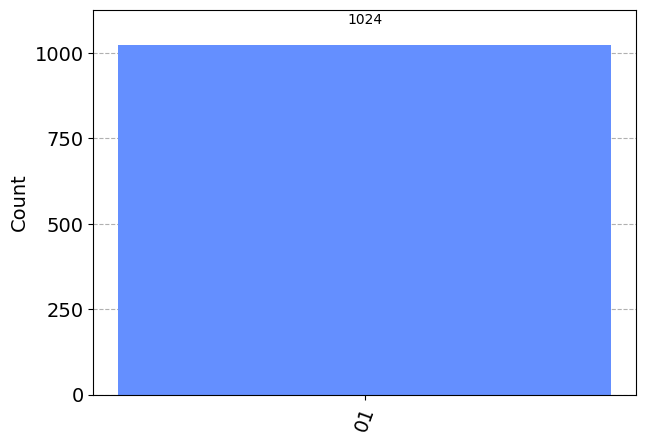

In [31]:
# call the simulator
aer_sim = Aer.get_backend('aer_simulator')

# run circuit
result = aer_sim.run(superdense_qc).result()
counts = result.get_counts(superdense_qc)

# display results
print(counts)
plot_histogram(counts)

Il simulatore simula un *computer quantistico perfetto* (che vedremo più avanti non essere equivalente alle macchine attualmente in circolazione). Dunque, dalla nostra simulazione otteniamo che misureremo il messaggio corretto senza alcun tipo di errore con probabilità certa.

## Algoritmo di Deutsch-Josza

Procederemo ora ad implementare l'algoritmo di Deutsch-Josza, il cui obiettivo è risolvere il seguente problema:*data in input una funzione $f : \{0, 1\}^n \rightarrow \{0, 1\}$, che è necessariamente costante o bilanciata, stabilire se f è costante o bilanciata*.

Per comodità, riportiamo i passaggi dell'algoritmo:
1. Prepariamo due registri quantistici, il primo inizializzato come $|0^n\rangle$ e il secondo inizializzato a $|1\rangle$
$$
    |\varphi_0\rangle = |0^n\rangle|1\rangle
$$
2. Generiamo una sovrapposizione equiprobabile applicando Hadamard a tutti i qubit
$$
    |\varphi_1\rangle = \frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^n - 1} |x\rangle (|0\rangle + |1\rangle)
$$
3. Applichiamo l'oracolo quantistico
$$
    |\varphi_2\rangle = \frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^n - 1} (-1)^{f(x)} |x\rangle (|0\rangle + |1\rangle)
$$
4. A questo punto ci concentriamo sui primi $n$ qubit e applichiamo nuovamente un Hadamard gate ad ognuno di essi:
$$
    |\varphi_3\rangle = \frac{1}{2^n} \sum_{y=0}^{2^n - 1} \Bigg[ \sum_{x=0}^{2^n - 1} (-1)^{f(x)} (-1)^{x\bullet y} \Bigg]
$$
5. Misuriamo il primo registro, dove otterremo $0^n$ se la funzione $f$ è costante e una qualsiasi altra stringa se invece è bilanciata.

### Deutsch-Jozsa a tre qubit
Iniziamo dunque a costruire il nostro circuito definendo innanzitutto la lunghezza del registro di input:

In [32]:
# set the length of the n-bit input string. 
n = 3

Procediamo poi con il costruire i nostri oracoli, uno per $f$ costante e uno per $f$ bilanciata, iniziando dal primo caso.

Infatti, se la funzione è costante, l'input non ha effetto sull'output di $f$ e possiamo dunque porlo randomicamente uguale a $0$ o a $1$:

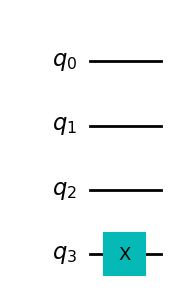

In [33]:
const_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

const_oracle.draw("mpl")

Se invece la funzione è bilanciata, costruiremo il nostro oracolo applicando un $\mathbf{CNOT}$ per ogni qubit di input con target sul qubit su cui salviamo l'output.

Infatti, il circuito così definito

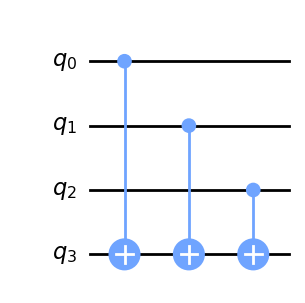

In [34]:
balanced_oracle = QuantumCircuit(n+1)

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

# Show oracle
balanced_oracle.draw('mpl')

è associato alla seguente tabella
<center>

| Input states that output 0 | Input states that output 1 |
|:---:|:---:|
| 000 |	001 |
| 011 |	100 |
| 101 |	010 |
| 110 |	111 |

</center>

Dunque applicare $\mathbf{CNOT}$ genera un oracolo corretto per la funzione bilanciata descritta in tabella, ma se avessimo una funzione bilanciata che funziona in modo diverso? In tal caso, ci basta applicare degli $\mathbf{X}$ gate prima e dopo la sequenza di $\mathbf{CNOT}$ così da avere la mappatura corretta, conservando la funzione come bilanciata.

Ad esempio

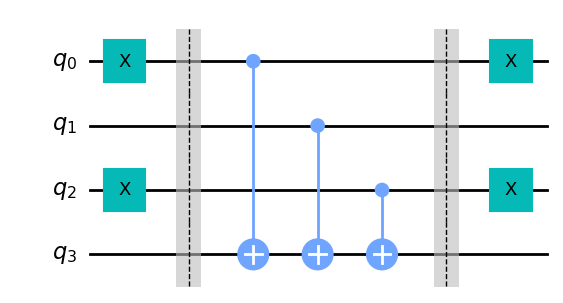

In [35]:
balanced_oracle = QuantumCircuit(n+1)

# Place X-gates
b_str = "101" # we use a string to handle info about X gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

# Use barrier as divider
balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw('mpl')

è associato alla seguente tabella
<center>

| Input states that output 0 | Input states that output 1 |
|:---:|:---:|
| 001 |	000 |
| 010 |	011 |
| 100 |	101 |
| 111 |	110 |

</center>

che è esattamente il comportamento che ci aspettiamo dal nostro oracolo per una funzione $f$ bilanciata!

Dunque, data una funzione bilanciata, siamo sempre in grado di definire un oracolo con questa forma, permettendoci di avanzare con l'algoritmo di Deutsch-Jozsa.

**Ex.4 - Costuire il circuito di Deutsch-Josza nel caso di $f$ bilanciata**

Link utili: [QuantumCircuit.compose](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.compose)

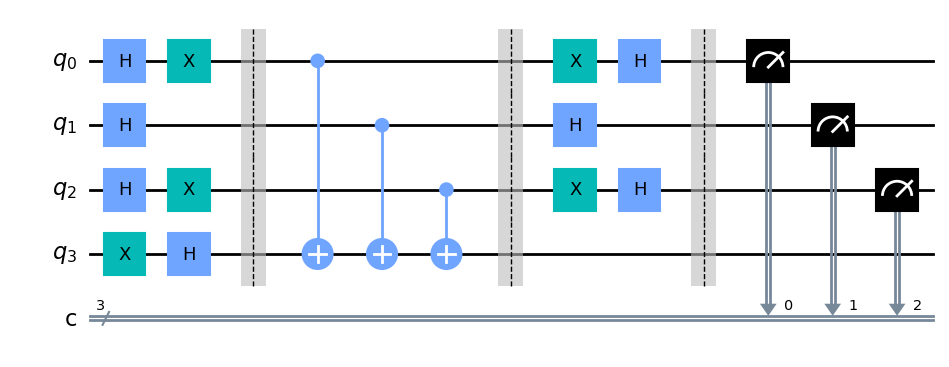

In [36]:
# add your code here
# hint: you can use for loops 
# if you have to apply the same operation to multiple qubits

# initialize the circuit
dj_circuit = QuantumCircuit(n+1, n)

# step 1: initialize qubits as |0^n>|1>
# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# step 2: apply H-gates 
# (hint: use a for loop)
for qubit in range(n):
    dj_circuit.h(qubit)

# step 3: add oracle
# (hint: use the function QC.compose)
dj_circuit = dj_circuit.compose(balanced_oracle)

# step 4: repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# step 5: add measurements
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')

Tramite simulatore, eseguiamo il nostro circuito e vediamo che risultati ci dà:

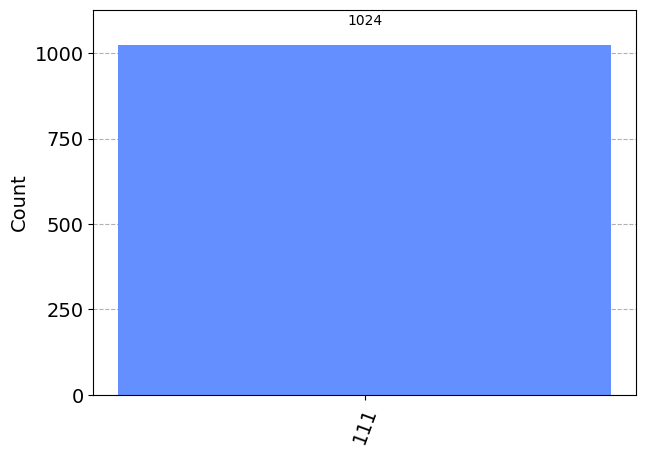

In [37]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
results = aer_sim.run(dj_circuit).result()
answer = results.get_counts()

plot_histogram(answer)

Possiamo dunque osservare che la probabilità di misurare $000$ è nulla, predicendo correttamente che $f$ è una funzione bilanciata.

### Deutsch-Jozsa generalizzato

Riportiamo anche una versione generalizzata dell'algoritmo di Deutsch-Jozsa, definendo due funzioni ausiliarie:
* `dj_oracle`, che definisce il circuito relativo all'oracolo, prendendo in input il caso che stiamo analizzando (i.e., $f$ costante o bilanciata);
* `dj_algorithm`, che prende in input l'oracolo ed esegue l'algoritmo.

In [38]:
def dj_oracle(case, n):

    oracle_qc = QuantumCircuit(n+1)
    
    # balanced case
    if case == "balanced":

        # first generate a random number that tells us 
        # which CNOTs to wrap in X-gates:
        b = np.random.randint(1,2**n)
    
        # format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')

        # place X gates on qubits based on the 1s in b_str
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

        # do the controlled-NOT gates for each qubit, 
        # using the output qubit as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)

        # place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # constant case
    if case == "constant":

        # first decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    # transform the circuit into a gate
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit

    return oracle_gate

In [39]:
def dj_algorithm(oracle, n):

    dj_circuit = QuantumCircuit(n+1, n)

    # set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)

    # set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)

    # append the oracle gate to the circuit:
    dj_circuit.append(oracle, range(n+1))

    # perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

Usiamo queste funzioni per giocare un po' con l'algoritimo:

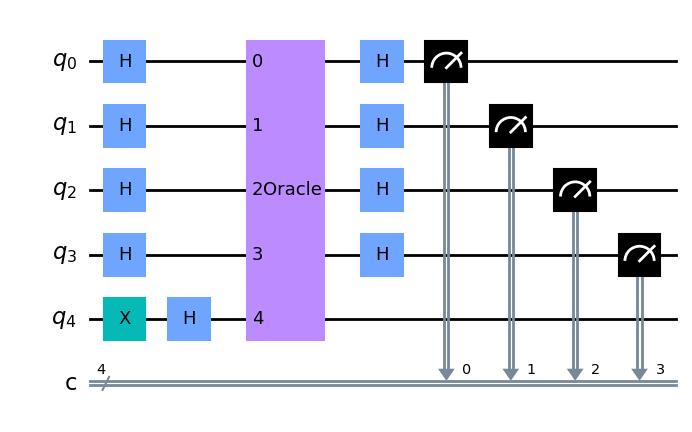

In [40]:
n = 4

oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)

dj_circuit.draw('mpl')

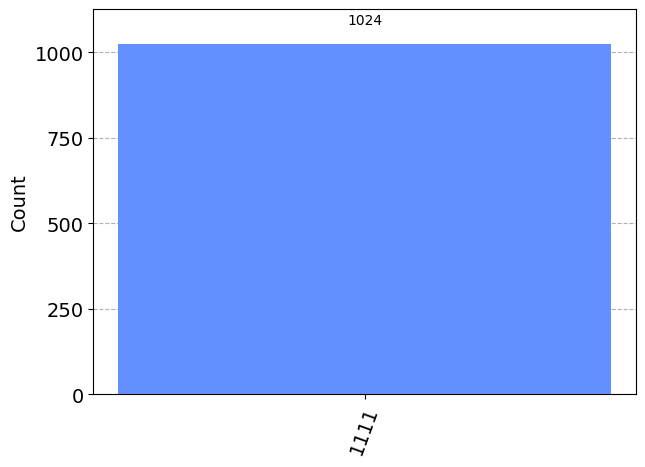

In [41]:
transpiled_dj_circuit = transpile(dj_circuit, aer_sim)

results = aer_sim.run(transpiled_dj_circuit).result()
answer = results.get_counts()

plot_histogram(answer)